In [70]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, precision_score
import gymnasium as gym
from gymnasium import spaces
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
from IPython.display import HTML


In [71]:
file_path = 'zip://clustered_data_4months.zip!clustered_data_4months (2).geojson'
data = gpd.read_file(file_path, driver="GeoJSON")

# Convert 'time' to datetime and sort by time
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time').reset_index(drop=True)

# Create time_step as an ordinal index
data['time_step'] = data.index

/Users/shashwatraj/Documents/GitHub/Code-Lab_RL_PriorityObs/tatcenv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


In [72]:
world = gpd.read_file('110m_cultural.zip', layer='ne_110m_admin_0_boundary_lines_land')
geometry = [Point(xy) for xy in zip(data['lon_sat'], data['lat_sat'])]
geo_full = gpd.GeoDataFrame(data, geometry=geometry)
geo_full['ground_track'] = geo_full.apply(lambda row: 0 if world.contains(row.geometry).any() else 1, axis=1)
data['ground_track'] = geo_full['ground_track']

In [73]:
data['lat_rad'] = np.radians(data['lat_sat'])
data['lon_rad'] = np.radians(data['lon_sat'])
data['x'] = np.cos(data['lat_rad']) * np.cos(data['lon_rad'])
data['y'] = np.cos(data['lat_rad']) * np.sin(data['lon_rad'])
data['z'] = np.sin(data['lat_rad'])

In [74]:
encoder = OneHotEncoder(sparse_output=False)
time_range_encoded = encoder.fit_transform(data[['time_range']])
time_range_feature_names = encoder.get_feature_names_out(['time_range'])
time_range_df = pd.DataFrame(time_range_encoded, columns=time_range_feature_names, index=data.index)
data = pd.concat([data, time_range_df], axis=1)

In [75]:
scaler = MinMaxScaler()
cols_to_scale = ['x', 'y', 'z', 'cnprcp_mean']
scaled_values = scaler.fit_transform(data[cols_to_scale])
data['x_norm'] = scaled_values[:, 0]
data['y_norm'] = scaled_values[:, 1]
data['z_norm'] = scaled_values[:, 2]
data['cnprcp_norm'] = scaled_values[:, 3]

In [76]:
def compute_orbit_ids(df, lon_threshold=358):
    
    df = df.copy()
    orbit_id = 0
    orbit_ids = [orbit_id]
    prev_lon = df.iloc[0]['lon_sat']
    for idx in range(1, len(df)):
        curr_lon = df.iloc[idx]['lon_sat']
        # Handle wrap-around: e.g., near 180 and -180 are close
        diff = abs(curr_lon - prev_lon)
        if diff > lon_threshold:
            orbit_id += 1
        orbit_ids.append(orbit_id)
        prev_lon = curr_lon
    df['orbit_id'] = orbit_ids
    return df

data = compute_orbit_ids(data, lon_threshold=300)

print("Number of orbits found:", data['orbit_id'].nunique())

Number of orbits found: 1448


In [77]:
class SatelliteOrbitEnv(gym.Env):
    def __init__(self, df, alpha=1.0, gamma=1.0, mu=1.0):
        super(SatelliteOrbitEnv, self).__init__()
        self.full_df = df.reset_index(drop=True)
        self.alpha = alpha
        self.gamma = gamma
        self.mu = mu

        self.action_space = spaces.Discrete(2)

        # Determine one-hot encoded time_range columns.
        self.one_hot_cols = [col for col in df.columns if col.startswith('time_range_')]
        self.n_one_hot = len(self.one_hot_cols)
        # Observation space: continuous features [x_norm, y_norm, z_norm, ground_track] (4 dims)
        # plus one-hot encoded time_range (n_one_hot dims)
        self.obs_dim = 4 + self.n_one_hot
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(self.obs_dim,), dtype=np.float32)

        # Prepare episodes: group by orbit_id
        self.episodes = [group for _, group in self.full_df.groupby('orbit_id')]
        self.current_episode = None
        self._index = 0

    def reset(self, seed=None, options=None):
        # Randomly select an orbit cycle (episode)
        self.current_episode = random.choice(self.episodes).reset_index(drop=True)
        self._index = 0
        return self._get_obs(), {}

    def step(self, action):
        reward = self._compute_reward(action)
        self._index += 1
        done = self._index >= len(self.current_episode) - 1
        obs = self._get_obs() if not done else np.zeros(self.obs_dim, dtype=np.float32)
        terminated = done
        truncated = False
        return obs, reward, terminated, truncated, {}

    def _get_obs(self):
        row = self.current_episode.iloc[self._index]
        # Continuous features: x_norm, y_norm, z_norm, ground_track.
        cont_features = np.array([
            row['x_norm'],
            row['y_norm'],
            row['z_norm'],
            float(row['ground_track'])
        ], dtype=np.float32)
        one_hot_features = row[self.one_hot_cols].values.astype(np.float32)
        return np.concatenate([cont_features, one_hot_features])
    
    def _compute_reward(self, action):
        row = self.current_episode.iloc[self._index]
        cnprcp_mean = row['cnprcp_mean']
        scale = 10000  # scaling factor to amplify small precipitation values
        if action == 1:
            if cnprcp_mean > 0:
                # Correct detection: give a base reward of 1 plus bonus proportional to intensity.
                reward = 1 + (cnprcp_mean * scale)
            else:
                # False positive: a small penalty for acting when there's no precipitation.
                reward = -0.1
        else:  # action == 0
            if cnprcp_mean > 0:
                reward = -0.01 + (cnprcp_mean * scale)
            else:
                reward = 0
        return reward
    

In [78]:
from sb3_contrib import QRDQN  # distributional RL (similar to C51)
from stable_baselines3.common.env_checker import check_env

all_f1_scores = []
all_precision_scores = []
all_rewards = []
all_episode_results = []


env = SatelliteOrbitEnv(data, alpha=1.0, gamma=1.0, mu=1.0)
check_env(env, warn=True)


model = QRDQN("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=100000)  


n_eval_episodes = 50
eval_rewards = []
all_predicted = []
all_actual = []

for i in range(n_eval_episodes):
    obs, _ = env.reset()
    done = False
    ep_reward = 0.0
    preds = []
    acts = []
    lats = []
    lons = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        preds.append(action)
        current_cprcp = env.current_episode.iloc[env._index]['cnprcp_mean']
        acts.append(1 if current_cprcp > 0 else 0)
        lats.append(env.current_episode.iloc[env._index]['lat_sat'])
        lons.append(env.current_episode.iloc[env._index]['lon_sat'])
        obs, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        done = terminated or truncated
    eval_rewards.append(ep_reward)
    f1 = f1_score(acts, preds, zero_division=0)
    precision = precision_score(acts, preds, zero_division=0)
    all_precision_scores.append(precision)
    all_f1_scores.append(f1)
    print(f"Episode {i}: F1 = {f1:.3f}, Reward = {ep_reward:.3f}")

    all_episode_results.append({
        "actual": acts,
        "predicted": preds,
        "lat": lats,
        "lon": lons,
    })

mean_f1 = np.mean(all_f1_scores)
mean_reward = np.mean(eval_rewards)
mean_precision = np.mean(all_precision_scores)
print(f"\nOverall: Mean F1 = {mean_f1:.3f}, Mean Precision = {mean_precision:.3f}, Mean Reward per Episode = {mean_reward:.3f}")

Episode 0: F1 = 0.125, Reward = 3.215
Episode 1: F1 = 0.000, Reward = 0.005
Episode 2: F1 = 0.000, Reward = -0.023
Episode 3: F1 = 0.000, Reward = 1.825
Episode 4: F1 = 0.000, Reward = 0.984
Episode 5: F1 = 0.000, Reward = 2.074
Episode 6: F1 = 0.000, Reward = -0.600
Episode 7: F1 = 0.000, Reward = 3.017
Episode 8: F1 = 0.250, Reward = 1.038
Episode 9: F1 = 0.000, Reward = 1.603
Episode 10: F1 = 0.000, Reward = 1.269
Episode 11: F1 = 0.000, Reward = 2.043
Episode 12: F1 = 0.000, Reward = -0.121
Episode 13: F1 = 0.000, Reward = 0.984
Episode 14: F1 = 0.000, Reward = 1.284
Episode 15: F1 = 0.000, Reward = 1.164
Episode 16: F1 = 0.000, Reward = -0.402
Episode 17: F1 = 0.000, Reward = -0.010
Episode 18: F1 = 0.000, Reward = 1.700
Episode 19: F1 = 0.000, Reward = 2.184
Episode 20: F1 = 0.000, Reward = 0.000
Episode 21: F1 = 0.000, Reward = 5.109
Episode 22: F1 = 0.000, Reward = -0.352
Episode 23: F1 = 0.000, Reward = -0.646
Episode 24: F1 = 0.000, Reward = 0.696
Episode 25: F1 = 0.000, Rewa

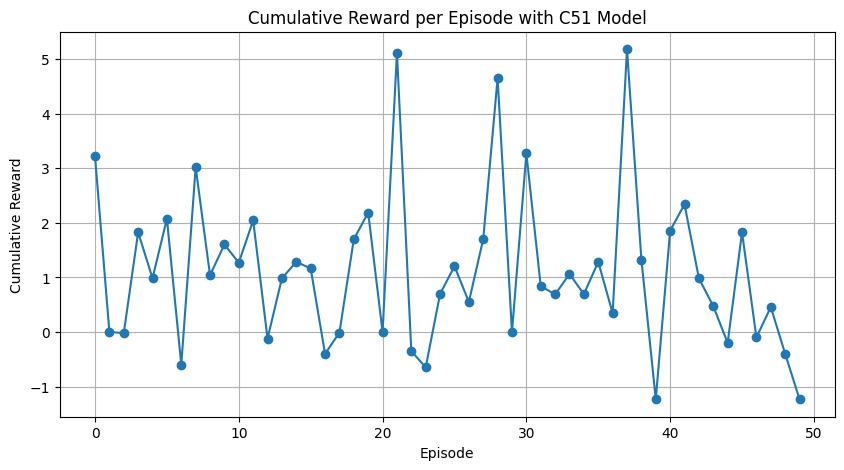

In [85]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 5))
plt.plot(eval_rewards, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward per Episode with C51 Model")
plt.grid(True)
plt.show()

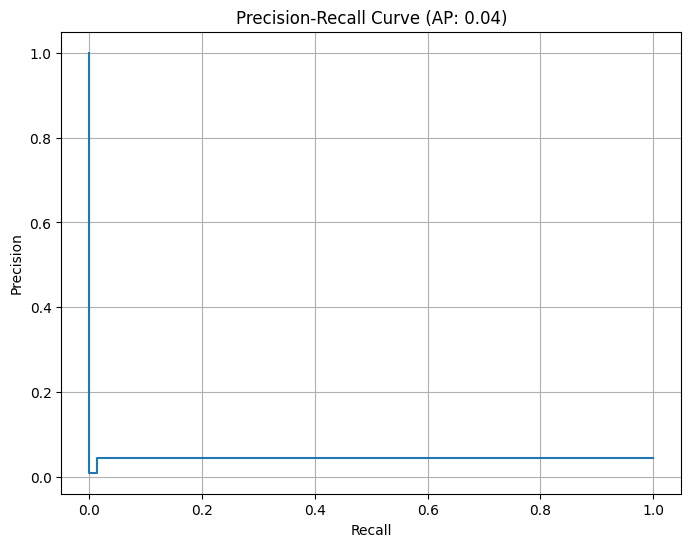

In [80]:
all_actual = []
all_predicted = []
for result in all_episode_results:
    all_actual.extend(result["actual"])
    all_predicted.extend(result["predicted"])

precision, recall, thresholds = precision_recall_curve(all_actual, all_predicted)
avg_precision = average_precision_score(all_actual, all_predicted)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP: {avg_precision:.2f})")
plt.grid(True)
plt.show()

In [81]:
df_list = []
for i, result in enumerate(all_episode_results):
    df_temp = pd.DataFrame(result)
    df_temp['episode'] = i  # mark each cycle by its index
    df_list.append(df_temp)

combined_df = pd.concat(df_list).reset_index(drop=True)
combined_df = combined_df.rename(columns={"lat": "lat_sat", "lon": "lon_sat"})


In [82]:
def modelResult(actual, predicted):
    if actual == 1 and predicted == 1:
        return "TP"
    elif actual == 0 and predicted == 1:
        return "FP"
    elif actual == 0 and predicted == 0:
        return "TN"
    elif actual == 1 and predicted == 0:
        return "FN"

combined_df["confusion"] = combined_df.apply(lambda row: modelResult(row["actual"], row["predicted"]), axis=1)
filtered_df = combined_df[combined_df["confusion"].isin(["TP", "FP"])]

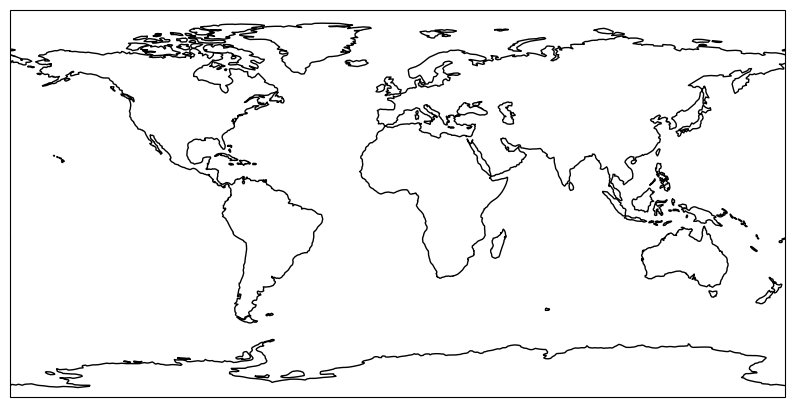

In [92]:
geometry = [Point(xy) for xy in zip(filtered_df["lon_sat"], filtered_df["lat_sat"])]
gdf = gpd.GeoDataFrame(filtered_df, geometry=geometry)
gdf.crs = "EPSG:4326"

episodes = sorted(gdf['episode'].unique())
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_global()
ax.coastlines()


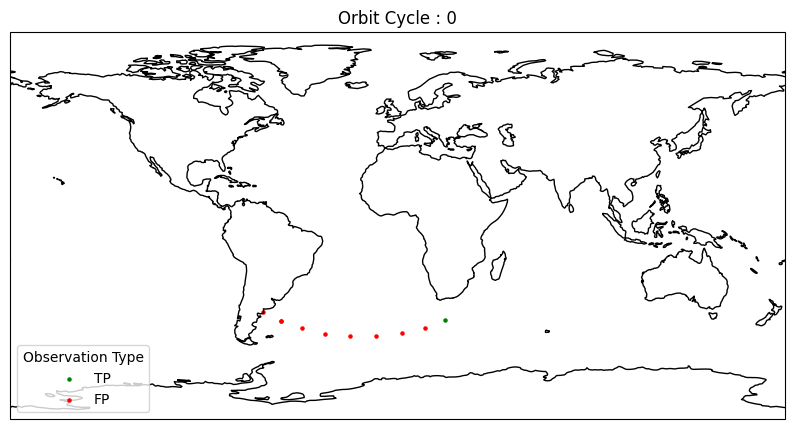

In [91]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})


color_map = {
    "TP": "green",
    "FP": "red"
}

scatter_handles = {}
def update(frame):
    while ax.collections:
        ax.collections[0].remove()
    
    current_episode = episodes[frame]
    episode_data = gdf[gdf['episode'] == current_episode]

    for label, color in color_map.items():
        subset = episode_data[episode_data["confusion"] == label]
        if not subset.empty:
            sc = ax.scatter(subset["lon_sat"], subset["lat_sat"], color=color,
                            transform=ccrs.PlateCarree(), s=5, label=label)
            scatter_handles[label] = sc
    
    ax.set_title(f"Orbit Cycle : {current_episode}")
    ax.legend(handles=list(scatter_handles.values()), title="Observation Type", loc="lower left")
    ax.set_global()
    ax.coastlines()

ani = FuncAnimation(fig, update, frames=len(episodes), interval=500)

HTML(ani.to_jshtml())


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


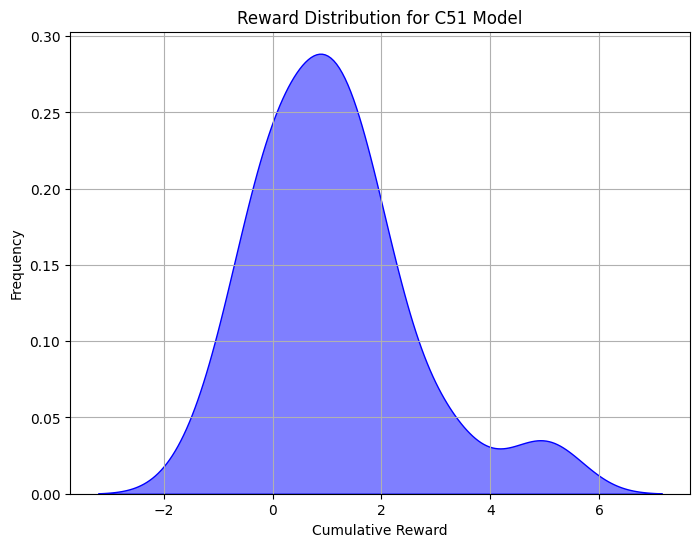

In [96]:
#plt.figure(figsize=(8,6))
%pip install seaborn
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(eval_rewards, ax=ax, fill=True, color='blue', alpha=0.5)
#plt.hist(eval_rewards, bins=20, edgecolor="black", alpha=0.75)
plt.xlabel("Cumulative Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution for C51 Model")
plt.grid(True)
plt.show()

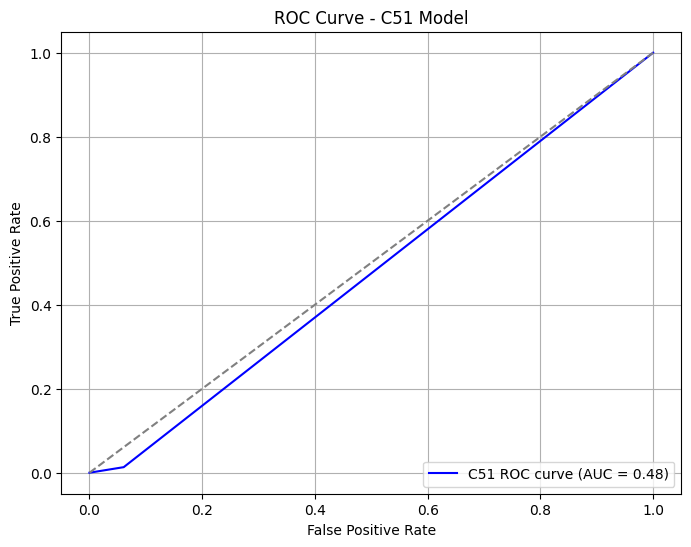

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score

all_actual_c51 = []
all_predicted_c51 = []
for result in all_episode_results:
    all_actual_c51.extend(result["actual"])
    all_predicted_c51.extend(result["predicted"])

fpr_c51, tpr_c51, thresholds = roc_curve(all_actual_c51, all_predicted_c51)
roc_auc_c51 = roc_auc_score(all_actual_c51, all_predicted_c51)

plt.figure(figsize=(8, 6))
plt.plot(fpr_c51, tpr_c51, label=f"C51 ROC curve (AUC = {roc_auc_c51:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - C51 Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()